<a href="https://colab.research.google.com/github/daniilstv/computer_vision/blob/master/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучить сиамскую сеть для верификации лиц на датасете LFW

In [ ]:
%tensorflow_version 2.x
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
ds = tfds.load('lfw', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete4E4H60/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.
<DatasetV1Adapter shapes: {image: (250, 250, 3), label: ()}, types: {image: tf.uint8, label: tf.string}>


In [ ]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

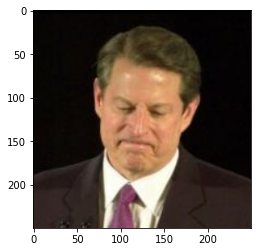

In [ ]:
for example in train_ds.take(22):
    image, label = example[1], example[0]

    plt.imshow(image.numpy().astype(np.float32)/255)
    # print(f"Label: {label}")

In [ ]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [ ]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 10

def normal(label, image):
    return label, tf.cast(image, tf.float32) / 255.

train_ds = train_ds.map(normal)
train_ds = train_ds.shuffle(buffer_size=5000, seed=42)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

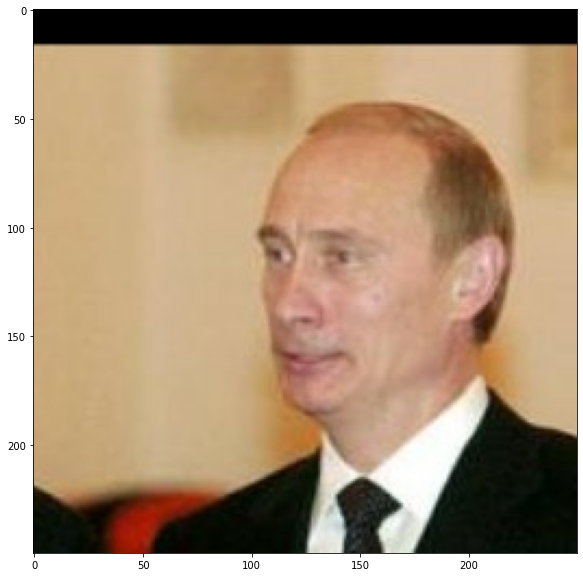

In [ ]:
sample = next(iter(train_ds))
plt.figure(figsize=(10,10))
plt.imshow(sample[1].numpy()[1].reshape(250,250,3))

In [ ]:
sample[0][1]

<tf.Tensor: shape=(), dtype=string, numpy=b'Vladimir_Putin'>

In [ ]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [ ]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 92.02139282226562
[200] Loss: 0.0
[400] Loss: 0.0
[600] Loss: 0.0024055547546595335


In [ ]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('/home/justin_timberlake.jpeg')
img_a2 = load_and_prepare_image('/home/justin_timberlake2.jpg')
img_b1 = load_and_prepare_image('/home/mel_gibson.jpg')




In [ ]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

In [ ]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:] #Justin Timberlake
emb2 = new_embs[1,:] #Justin Timberlake 2
emb3 = new_embs[2,:] #Mel Gibson


print('Justin <-> Justin2: ', diff(emb1, emb2))
print('Justin<-> Mel_Gibson: ', diff(emb1, emb3))
print('Justin2 <-> Mel_Gibson: ', diff(emb2, emb3))